### Загрузим датасет

In [1]:
import h5py
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dataset = h5py.File('/home/kmouraviev/NYU_dataset_hdf5/data.hdf5', 'r')
rgbs = dataset['data']
depths = dataset['label']

In [3]:
rgbs = np.array(rgbs)
depths = np.array(depths)

In [4]:
sample_ids = np.random.choice(np.arange(len(rgbs)), size=1000, replace=False)
rgbs_sample = rgbs[sample_ids]
depths_sample = depths[sample_ids]

In [5]:
rgbs_train = rgbs[:40000]
depths_train = depths[:40000]
rgbs_val = rgbs[40000:]
depths_val = depths[40000:]

### Получим предсказанные нейросетью глубины

In [6]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [7]:
from keras.models import load_model
model = load_model('/home/kmouraviev/FCRN_notebooks/finetune_sgd_lr1e-05_decay1e-05/model_on_epoch1.hdf5')

In [8]:
depths_sample_predicted = model.predict(rgbs_sample)

## Bilateral Inception

Алгоритм взят из статьи https://pdfs.semanticscholar.org/727d/31a2838a67955d213bb4e1b72d19812877e7.pdf

Сначала попробуем в качестве суперпикселей использовать просто квадраты 7х7. В качестве фичей - координаты и саму глубину.

### Создадим обучающую выборку

In [9]:
MAX_DEPTH = 10

In [10]:
def extract_superpixels(image):
    superpixels = []
    for i in range(0, image.shape[0], 7):
        for j in range(0, image.shape[0], 7):
            superpixels.append(image[i:i+7, j:j+7].mean() / MAX_DEPTH)
    return np.array(superpixels)

In [11]:
def extract_features(image):
    features = []
    for i in range(0, image.shape[0], 7):
        for j in range(0, image.shape[0], 7):
            features.append([(i + 4) / image.shape[0], (j + 4) / image.shape[1], image[i:i+7, j:j+7].mean() / MAX_DEPTH])
    return np.array(features)

In [12]:
from tqdm import tqdm_notebook

In [13]:
prediction_superpixels = np.array([extract_superpixels(image) for image in tqdm_notebook(depths_sample_predicted)])
gt_superpixels = np.array([extract_superpixels(image) for image in tqdm_notebook(depths_sample)])
prediction_features = np.array([extract_features(image) for image in tqdm_notebook(depths_sample_predicted)])

In [14]:
prediction_superpixels = prediction_superpixels[:, :, np.newaxis]
gt_superpixels = gt_superpixels[:, :, np.newaxis]

In [15]:
print(prediction_superpixels.shape, gt_superpixels.shape, prediction_features.shape)

(1000, 1024, 1) (1000, 1024, 1) (1000, 1024, 3)


### Зададим переменные фильтра

In [16]:
feature_plh = tf.placeholder(tf.float64, shape=(None, 1024, 3))
z_plh = tf.placeholder(tf.float64, shape=(None, 1024, 1))
gt_plh = tf.placeholder(tf.float64, shape=(None, 1024, 1))

In [17]:
Lambda = tf.Variable(np.eye(3), dtype=tf.float64, trainable=True)
theta = tf.Variable([1], dtype=tf.float64, trainable=True)

In [18]:
Lf = tf.einsum('ijk,kl->ijl', feature_plh, tf.transpose(Lambda))

In [19]:
# D_ij = ||Lf_i - Lf_j||^2
lf1_tiled = tf.tile(tf.expand_dims(Lf, axis=1), [1, 1024, 1, 1])
lf2_tiled = tf.tile(tf.expand_dims(Lf, axis=2), [1, 1, 1024, 1])
D = tf.reduce_sum((lf1_tiled - lf2_tiled) ** 2, axis=-1)

In [20]:
theta_D = theta * D
K = tf.nn.softmax(theta_D, axis=2)

In [21]:
z_new = tf.einsum('ijk,ikl->ijl', K, z_plh)

### Зададим оптимизатор

In [22]:
loss = tf.losses.mean_squared_error(z_new, gt_plh)
optimizer = tf.train.AdamOptimizer(1e-2)
train_step = optimizer.minimize(loss)

### Запустим обучение

In [23]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [24]:
from tqdm import tqdm

In [25]:
BATCH_SIZE = 16

In [27]:
loss_history = []
for i in tqdm(range(3000)):
    ids = np.random.choice(np.arange(len(depths_sample)), size=BATCH_SIZE, replace=False)
    features = prediction_features[ids]
    gt = gt_superpixels[ids]
    prediction = prediction_superpixels[ids]
    feed_dict = {feature_plh: features,
                z_plh: prediction,
                gt_plh: gt
               }
    loss_value, _ = sess.run([loss, train_step], feed_dict=feed_dict)
    loss_history.append(loss_value)

100%|██████████| 3000/3000 [01:02<00:00, 47.96it/s]


In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
def running_mean(x, n):
    cumsum = np.cumsum(x)
    return (cumsum[n:] - cumsum[:-n]) / n

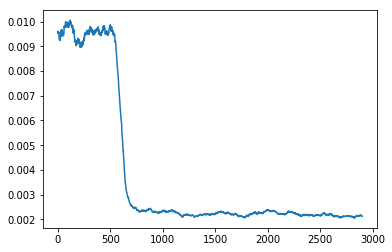

In [30]:
plt.plot(running_mean(loss_history, 100))

### Построим предсказания билатерального фильтра

In [31]:
batch_size = 20
filtered_batches = []
for i in range(0, len(prediction_superpixels), batch_size):
    superpixel_batch = prediction_superpixels[i:i + batch_size]
    feature_batch = prediction_features[i:i + batch_size]
    filtered_batch = sess.run(z_new, feed_dict={z_plh: superpixel_batch, 
                                                 feature_plh: feature_batch
                                                })
    filtered_batches.append(filtered_batch)

In [32]:
sample_predictions_filtered = np.concatenate(filtered_batches, axis=0)

In [33]:
print("MSE:", np.mean((sample_predictions_filtered - gt_superpixels) ** 2))

MSE: 0.002191018706505358


In [34]:
print('std of filtered:', sample_predictions_filtered.std())
print('std of source:', gt_superpixels.std())

std of filtered: 0.14653734803019577
std of source: 0.15103237482716678


### Добавим сглаживание гауссовским ядром

Итоговое предсказание глубины строится так: сначала инициализируем каждый пиксель значением суперпикселя, в котором он находится, затем сглаживаем изображение гауссовским ядром.

In [35]:
import scipy.stats as sps

def apply_gaussian_filter(source_image,
                          filtered_superpixels,
                          sigma=7,
                          k=5):
    image = source_image.copy()
    grid_x, grid_y = np.meshgrid(np.arange(-(k // 2), k // 2 + 1),
                                 np.arange(-(k // 2), k // 2 + 1))
    grid = np.array(list(zip(grid_x.ravel(), grid_y.ravel()))).reshape((k, k, 2))
    gaussian_window = sps.multivariate_normal(mean=[0, 0], cov=np.eye(2) * sigma).pdf(grid)
    gaussian_window /= gaussian_window.sum()
    for n in range(1024):
        i = (n // 32) * 7
        j = (n % 32) * 7
        image[i:i+7, j:j+7] = filtered_superpixels[n]
    for i in range(k // 2, source_image.shape[0] - k // 2):
        for j in range(k // 2, source_image.shape[1] - k // 2):
            image[i, j] = np.sum(image[i - k // 2:i + k // 2 + 1, j - k // 2:j + k // 2 + 1] \
                                 * gaussian_window)
    return image

In [36]:
%%time
filtered_image = apply_gaussian_filter(depths_sample_predicted[0] / 10., sample_predictions_filtered[0])

CPU times: user 524 ms, sys: 1.16 ms, total: 525 ms
Wall time: 522 ms


Работает довольно долго, но наверняка можно значительно оптимизировать.

### Визуализируем работу фильтра

In [38]:
predictions_to_see = depths_sample_predicted[::50]
filtered_predictions_to_see = sample_predictions_filtered[::50]
gts_to_see = depths_sample[::50]
rgbs_to_see = rgbs_sample[::50]

In [39]:
def unpreprocess(image):
    img_min = -123
    img_max = 151
    return (image - img_min) / (img_max - img_min)

100%|██████████| 20/20 [00:11<00:00,  1.75it/s]


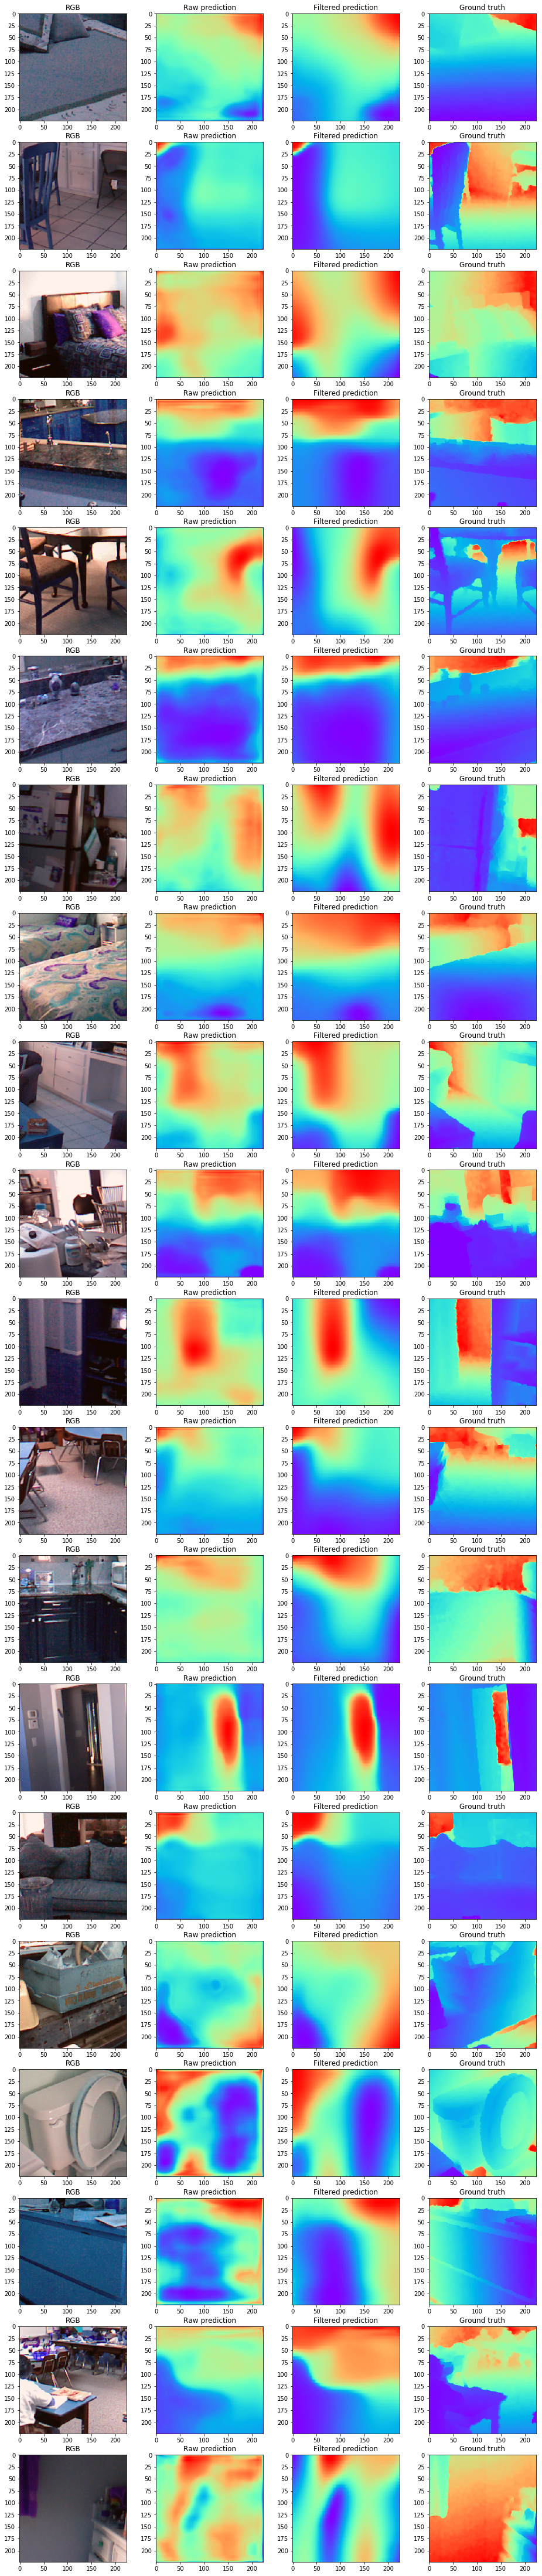

In [40]:
from tqdm import tqdm

n = len(predictions_to_see)
plt.figure(figsize=(16, n * 4))
for i in tqdm(range(n)):
    plt.subplot(n, 4, i * 4 + 1)
    plt.title('RGB', fontsize=12)
    plt.imshow(unpreprocess(rgbs_to_see[i]))
    
    plt.subplot(n, 4, i * 4 + 2)
    plt.title('Raw prediction', fontsize=12)
    plt.imshow(predictions_to_see[i] / 10., cmap='rainbow')
    
    plt.subplot(n, 4, i * 4 + 3)
    plt.title('Filtered prediction', fontsize=12)
    filtered_prediction = apply_gaussian_filter(predictions_to_see[i],
                                                filtered_predictions_to_see[i],
                                                sigma=7,
                                                k=7
                                                )
    plt.imshow(filtered_prediction, cmap='rainbow')
    
    plt.subplot(n, 4, i * 4 + 4)
    plt.title('Ground truth', fontsize=12)
    plt.imshow(gts_to_see[i], cmap='rainbow')

Визуально отфильтрованные изображения стали выглядеть попряитнее - границы стали четче

### Сравним качество (по метрике MSE)

In [45]:
from tqdm import tqdm_notebook

filtered_predictions = []
for i in tqdm_notebook(np.arange(1000)):
    filtered_prediction = apply_gaussian_filter(depths_sample_predicted[i],
                                                sample_predictions_filtered[i],
                                                sigma=7,
                                                k=7
                                                )
    filtered_predictions.append(filtered_prediction)

In [46]:
filtered_predictions = np.array(filtered_predictions)

In [47]:
print("MSE of raw predictions:", np.mean((depths_sample_predicted - depths_sample) ** 2))
print("MSE of filtered predictions:", np.mean((filtered_predictions * 10 - depths_sample) ** 2))

MSE of raw predictions: 0.2508066953433228
MSE of filtered predictions: 0.23486743929263637


In [51]:
print("log-MSE of raw predictions:", np.mean((np.log(depths_sample_predicted + 1e-2) - \
                                              np.log(depths_sample + 1e-2)) ** 2))
print("log-MSE of filtered predictions:", np.mean((np.log(filtered_predictions * 10 + 1e-2) - \
                                              np.log(depths_sample + 1e-2)) ** 2))

log-MSE of raw predictions: 0.07682256537137902
log-MSE of filtered predictions: 0.05164659494873997


По метрикам качество работы тоже улучшилось.